# Feature Selection Techniques - Regression Example

As a data scientist or machine learning enthusiast, you know that building an accurate and efficient machine learning model is no small feat. By selecting the most relevant and informative features from your dataset, you can significantly improve the accuracy and efficiency of your model. That's where feature selection comes in. It's one of the several ways to improve your machine learning models, in addition to feature engineering, hyperparameter tuning, regularisation and data preprocessing.


**Feature selection** is the process of selecting the most relevant and informative features from your dataset. As the old saying goes, "garbage in, garbage out" - if your dataset contains irrelevant or noisy features, your model's performance will suffer, no matter how good your algorithm or hyperparameters are.

**This notebook covers:**
1. Filter methods
2. Wrapper methods
3. Embedded methods

These are applied to the automobile dataset, where we predict the price of a car based on its variaous characteristics.
https://www.kaggle.com/datasets/toramky/automobile-dataset


## Imports

In [130]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing and modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV


pd.set_option('display.max_columns', None)

# Automobile dataset

In [131]:
data = 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/automobile.csv'
df_in = pd.read_csv(data)

df_in

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
198,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
199,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.4,23.0,106,4800,26,27,22470
200,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3062,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,19,25,22625


In [132]:
df.columns

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [133]:
df = df_in.copy()

# Drop categorical cols
df = df.drop(columns=['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'])

# Convert problem columns to numeric. Error values will become nulls and dropped later.
# This is for numeric columns with some non-numeric values "?" for missing.
for col in ['peak-rpm', 'bore', 'stroke', 'horsepower']:

    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with nulls
df = df.dropna().reset_index(drop=True)

# Prepare input features and target
X = df.drop(columns=['price'])
y = df['price']

# Get the numeric column names
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Normalize the numeric columns using MinMaxScaler
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X = pd.get_dummies(X, drop_first=True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



X_train

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
67,0.6,0.298429,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
114,0.4,0.083770,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.457143,0.125000,0.092105,0.265306,0.352941,0.388889
11,0.6,0.277487,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.552381,0.150625,0.131579,0.551020,0.647059,0.638889
65,0.6,0.329843,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
85,0.6,0.282723,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.552381,0.150000,0.131579,0.551020,0.647059,0.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.4,0.214660,0.365517,0.525203,0.429825,0.509615,0.315749,0.299492,0.564286,0.666667,0.093750,0.322368,0.428571,0.352941,0.444444
106,0.4,0.125654,0.358621,0.526829,0.447368,0.346154,0.311094,0.238579,0.771429,0.271429,0.125000,0.223684,0.265306,0.382353,0.388889
14,0.6,0.434555,0.244828,0.263415,0.307018,0.115385,0.185803,0.147208,0.307143,0.552381,0.150000,0.131579,0.551020,0.470588,0.555556
92,1.0,0.445026,0.431034,0.739837,0.543860,0.644231,0.453840,0.304569,0.714286,0.476190,0.144375,0.407895,0.448980,0.176471,0.277778


# Fit base model

## Linear Regression

In [135]:
def fit_linear_reg(X_train, y_train, X_test, y_test):
    """
    Fits a linear regression model on the training data and evaluates it on the test data using
    root mean squared error (RMSE), mean absolute error (MAE).
    """

    # Instantiate a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    print('RMSE:', round(rmse, 2), 'MAE:', round(mae, 2))

    return model

In [136]:
# reg = fit_logistic_reg(X_train, y_train, X_test, y_test)
reg = fit_linear_reg(X_train, y_train, X_test, y_test)

RMSE: 2589.05 MAE: 2010.8


## Define function to plot feature importances
We will use this in the below techniques

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_importances(df_in, title):
  """make a horizontal bar chart of feature importances"""

  # Plot the feature importances in sorted order
  # Set plot style
  plt.style.use('seaborn-darkgrid')

  # Create horizontal bar plot
  sns.set_style('whitegrid')
  cmap = sns.color_palette('rocket_r', as_cmap=True)
  fig, ax = plt.subplots(figsize=(7, 9))
  sns.barplot(x='Importance', y='Feature', data=df_in, orient='h')
  ax.set_title(title, fontsize=16)
  ax.set_xlabel('Importance Scores', fontsize=12)
  ax.set_ylabel('Features', fontsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.invert_yaxis()
  plt.show()
  

# 1. Filter methods

In [138]:
n_features = 11

## Pearson correlation

Pearson correlation feature selection measures the linear relationship between features and the target variable. This technique is useful for identifying important features in regression problems where the target variable is continuous. The correlation coefficient is used to measure the strength and direction of the linear relationship. However, Pearson correlation assumes a linear relationship and may miss non-linear relationships or complex interactions between features.

**Pros:**
- Measures the linear relationship between features and the target variable
- Can identify both positive and negative correlations
- Relatively easy to interpret and explain

**Cons:**
- Assumes a linear relationship between features and the target variable
- May miss non-linear relationships between features and the target variable
- Does not capture complex interactions between features

Selected features: ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'compression-ratio', 'horsepower', 'city-mpg', 'highway-mpg']


C:\Users\hjurz\AppData\Local\Temp\ipykernel_19460\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


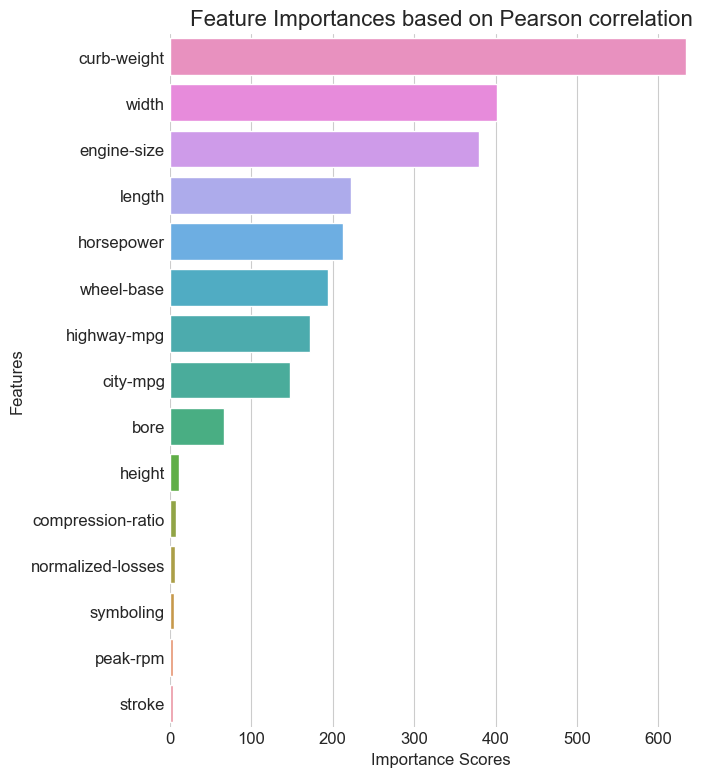

,wheel-base,length,width,height,curb-weight,engine-size,bore,compression-ratio,horsepower,city-mpg,highway-mpg
67,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.150000,0.138158,0.470588,0.527778
114,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.125000,0.092105,0.352941,0.388889
11,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.150625,0.131579,0.647059,0.638889
65,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.150000,0.138158,0.470588,0.527778
85,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.150000,0.131579,0.647059,0.638889


In [139]:
from sklearn.feature_selection import SelectKBest, f_regression

# Apply Pearson correlation feature selection to select the top features
selector = SelectKBest(f_regression, k=n_features)
X_filter = selector.fit_transform(X, y)

# Get the indices of the selected features
mask = selector.get_support()

# Make dataframe with new features
X_train_corr = X_train.loc[:,mask]
X_test_corr = X_test.loc[:,mask]
new_features = X_train.loc[:,mask].columns.tolist()

# Get the feature importances and plot
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train.columns, scores)}
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)

# Print the selected features
print("Selected features:", new_features)
plot_importances(feature_importances, 'Feature Importances based on Pearson correlation')

# Preview filtered dataset
X_train_corr.head()


## Spearman's Rank

Selected features: ['symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'horsepower', 'city-mpg', 'highway-mpg']


C:\Users\hjurz\AppData\Local\Temp\ipykernel_19460\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


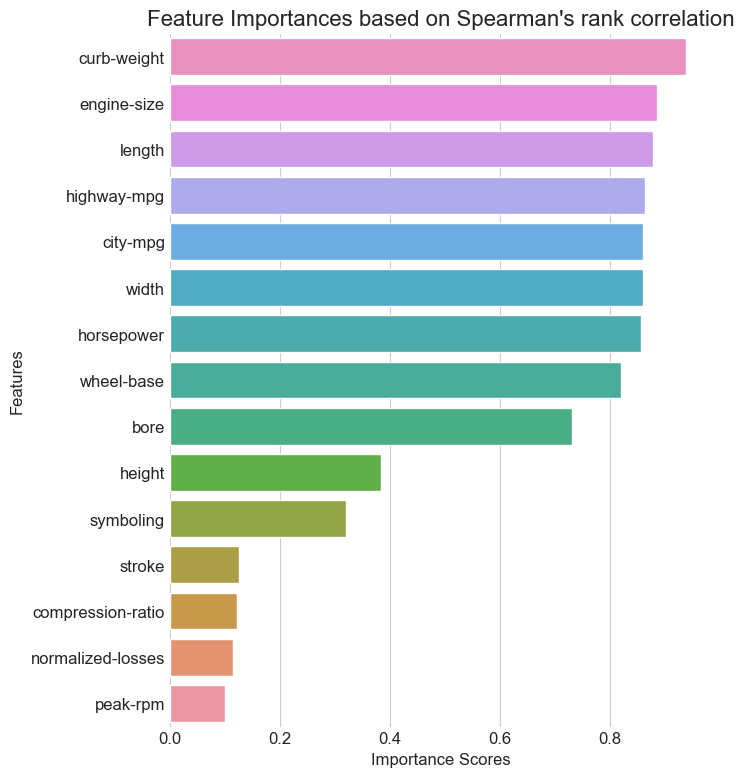

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,horsepower,city-mpg,highway-mpg
67,0.6,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.138158,0.470588,0.527778
114,0.4,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.092105,0.352941,0.388889
11,0.6,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.131579,0.647059,0.638889
65,0.6,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.138158,0.470588,0.527778
85,0.6,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.131579,0.647059,0.638889


In [140]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest

# Define a custom scoring function that calculates the Spearman's rank correlation
def spearman_correlation(X, y):
    corrs = np.array([spearmanr(X[:, i], y)[0] for i in range(X.shape[1])])
    return np.abs(corrs), np.zeros_like(corrs)

# Apply the custom scoring function to SelectKBest
selector = SelectKBest(score_func=spearman_correlation, k=n_features)
selector.fit(X_train, y_train)

# Get the indices of the selected features
mask = selector.get_support()

# Make dataframe with new features
X_train_spearman = X_train.loc[:, mask]
X_test_spearman = X_test.loc[:, mask]
new_features = X_train.loc[:, mask].columns.tolist()

# Get the feature importances and plot
scores = selector.scores_
feature_importances = {feature_name: score for feature_name, score in zip(X_train.columns, scores)}
feature_importances = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=True)

# Print the selected features
print("Selected features:", new_features)
plot_importances(feature_importances, 'Feature Importances based on Spearman\'s rank correlation')

# Preview filtered dataset
X_train_spearman.head()

### Test linear regression using selscted features

In [141]:
print("\nBase Model:")
reg = fit_linear_reg(X_train, y_train, X_test, y_test)

print("\nFeature selection by Pearson Correlation:")
reg = fit_linear_reg(X_train_corr, y_train, X_test_corr, y_test)

print("\nFeature selection by Spearman's Rank:")
reg = fit_linear_reg(X_train_spearman, y_train, X_test_spearman, y_test)


Base Model:
RMSE: 2589.05 MAE: 2010.8

Feature selection by Pearson Correlation:
RMSE: 2398.24 MAE: 1887.54

Feature selection by Spearman's Rank:
RMSE: 2452.41 MAE: 1941.15


# 2. Wrapper methods

## Recursive feature elimination (RFE)

Selected features:
Index(['normalized-losses', 'wheel-base', 'length', 'width', 'height',
       'curb-weight', 'engine-size', 'bore', 'stroke', 'city-mpg',
       'highway-mpg'],
      dtype='object')


C:\Users\hjurz\AppData\Local\Temp\ipykernel_19460\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


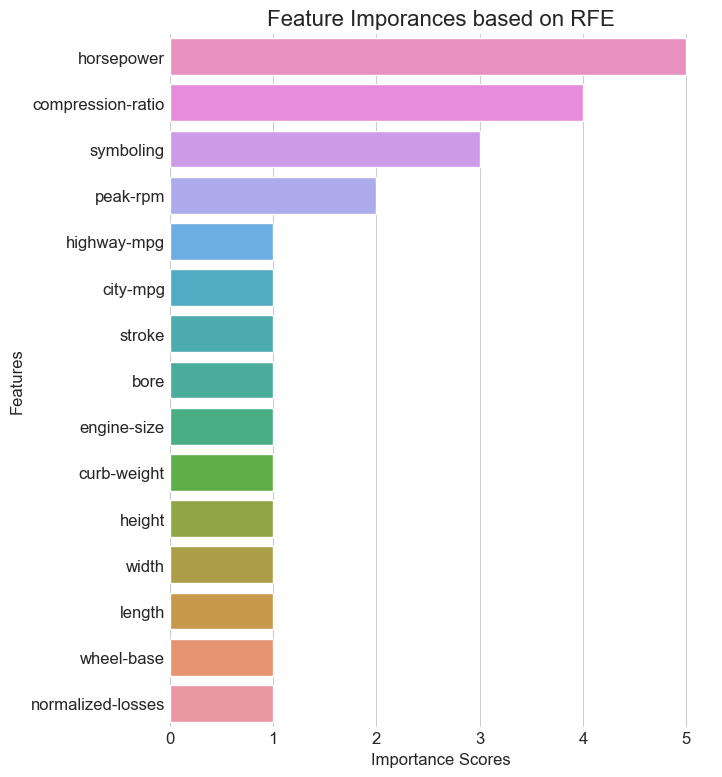

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,city-mpg,highway-mpg
67,0.298429,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.580952,0.470588,0.527778
114,0.083770,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.457143,0.352941,0.388889
11,0.277487,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.552381,0.647059,0.638889
65,0.329843,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.580952,0.470588,0.527778
85,0.282723,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.552381,0.647059,0.638889
...,...,...,...,...,...,...,...,...,...,...,...
71,0.214660,0.365517,0.525203,0.429825,0.509615,0.315749,0.299492,0.564286,0.666667,0.352941,0.444444
106,0.125654,0.358621,0.526829,0.447368,0.346154,0.311094,0.238579,0.771429,0.271429,0.382353,0.388889
14,0.434555,0.244828,0.263415,0.307018,0.115385,0.185803,0.147208,0.307143,0.552381,0.470588,0.555556
92,0.445026,0.431034,0.739837,0.543860,0.644231,0.453840,0.304569,0.714286,0.476190,0.176471,0.277778


In [142]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create a model object 
model = LinearRegression()

# Create a Recursive Feature Elimination object
rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)

# Fit the RFE object to the data
rfe.fit(X_train, y_train.values.ravel())

# Filter the dataset for the selected features
X_train_rfe = X_train.iloc[:,rfe.support_]
X_test_rfe = X_test.iloc[:,rfe.support_]
selected_features = X_train_rfe.columns

# Print the selected features
print('Selected features:')
print(selected_features)

# Get the feature importances and plot
df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rfe.ranking_})
df_importance = df_importance.sort_values(by='Importance', ascending=True)
plot_importances(df_importance, 'Feature Imporances based on RFE')

# Show the filtered dataset
X_train_rfe

## Sequential feature selection (SFS)

In [143]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create a model object 
model = LinearRegression()

# Create a Sequential Feature Selector object
sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features, direction='forward')

# Fit the Sequential Feature Selector object to the data
sfs.fit(X_train, y_train.values.ravel())

# Filter the dataset for the selected features
X_train_sfs = X_train.iloc[:,sfs.support_]
X_test_sfs = X_test.iloc[:,sfs.support_]
selected_features = X_train_sfs.columns.tolist()

# Print the selected features
print('Selected features:')
print(selected_features)

# Show the filtered dataset
X_train_sfs

Selected features:
['symboling', 'normalized-losses', 'width', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']


,symboling,normalized-losses,width,curb-weight,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
67,0.6,0.298429,0.307018,0.187355,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
114,0.4,0.083770,0.289474,0.311094,0.364286,0.457143,0.125000,0.092105,0.265306,0.352941,0.388889
11,0.6,0.277487,0.307018,0.150504,0.307143,0.552381,0.150625,0.131579,0.551020,0.647059,0.638889
65,0.6,0.329843,0.307018,0.179597,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
85,0.6,0.282723,0.307018,0.166796,0.307143,0.552381,0.150000,0.131579,0.551020,0.647059,0.638889
...,...,...,...,...,...,...,...,...,...,...,...
71,0.4,0.214660,0.429825,0.315749,0.564286,0.666667,0.093750,0.322368,0.428571,0.352941,0.444444
106,0.4,0.125654,0.447368,0.311094,0.771429,0.271429,0.125000,0.223684,0.265306,0.382353,0.388889
14,0.6,0.434555,0.307018,0.185803,0.307143,0.552381,0.150000,0.131579,0.551020,0.470588,0.555556
92,1.0,0.445026,0.543860,0.453840,0.714286,0.476190,0.144375,0.407895,0.448980,0.176471,0.277778


In [158]:
X_train.shape

(112, 15)

In [144]:
print("\nBase Model:")
reg = fit_linear_reg(X_train, y_train, X_test, y_test)

print("\nFeature selection by RFE:")
reg = fit_linear_reg(X_train_rfe, y_train, X_test_rfe, y_test)

print("\nFeature selection by SFS:")
reg = fit_linear_reg(X_train_sfs, y_train, X_test_sfs, y_test)


Base Model:
RMSE: 2589.05 MAE: 2010.8

Feature selection by RFE:
RMSE: 2648.56 MAE: 2018.1

Feature selection by SFS:
RMSE: 2519.85 MAE: 1916.7


# 3 Embedded methods

In [145]:
def eval_regress(model, X_train, X_test, y_test):
    # Compute predictions on the test set
    y_pred = model.predict(X_test)

    # Compute the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    # print('MSE:', round(mse, 2))
    print('RMSE:', round(rmse, 2), 'MAE:', round(mae, 2))
    # print('MAE:', round(mae, 2))
    # print('R-squared:', round(r2, 3))

## Ridge Regression

In [146]:
from sklearn.linear_model import RidgeCV

# Create a RidgeCV object
ridge = RidgeCV(cv=5)

# Fit the RidgeCV object to the data
ridge.fit(X_train, y_train.ravel())

# Create a boolean mask of the selected features
mask = ridge.coef_ != 0

# Get the names of the selected features
selected_features = X_train.columns[mask]

# Create a dataframe with the selected features
df_selected = pd.DataFrame(X_train[selected_features], columns=selected_features)

# Print the selected features
print('Selected features:')
print(selected_features.tolist())

# Show the filtered dataframe
df_selected.head()

Selected features:
['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
67,0.6,0.298429,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
114,0.4,0.083770,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.457143,0.125000,0.092105,0.265306,0.352941,0.388889
11,0.6,0.277487,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.552381,0.150625,0.131579,0.551020,0.647059,0.638889
65,0.6,0.329843,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.580952,0.150000,0.138158,0.428571,0.470588,0.527778
85,0.6,0.282723,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.552381,0.150000,0.131579,0.551020,0.647059,0.638889


In [147]:
eval_regress(ridge, X_train, X_test, y_test)

RMSE: 2386.68 MAE: 1876.46


## Lasso regression
Lasso regression, similar to ridge regression, is a regularization technique used to prevent overfitting in linear regression models. Instead of adding a penalty term proportional to the square of the coefficients as in ridge regression, lasso regression adds a penalty term proportional to the absolute value of the coefficients. This has the effect of shrinking some coefficients all the way to zero, effectively removing some features entirely from the model.

Lasso regression is often used for feature selection as a result of this property, as it can be used to identify the most important predictors in a dataset. Like ridge regression, the strength of the penalty term is controlled by the regularization parameter, which is typically chosen through cross-validation. Lasso regression can be particularly useful in situations where there are many predictors but only a few are expected to have a strong effect on the outcome, or where the goal is to identify a parsimonious model that uses as few predictors as possible without sacrificing too much predictive power.

In [148]:
from sklearn.linear_model import LassoCV

# Create a LassoCV object
lasso = LassoCV(cv=5)

# Fit the LassoCV object to the data
lasso.fit(X_train, y_train.ravel())

# Create a boolean mask of the selected features
mask = lasso.coef_ != 0

# Get the names of the selected features
selected_features = X_train.columns[mask]

# Create a dataframe with the selected features
df_selected = pd.DataFrame(X_train[selected_features], columns=selected_features)

# Print the selected features
print('Selected features:')
print(selected_features.tolist())

# Show the filtered dataframe
df_selected.head()

Selected features:
['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'peak-rpm', 'city-mpg']


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,peak-rpm,city-mpg
67,0.6,0.298429,0.272414,0.393496,0.307018,0.490385,0.187355,0.182741,0.435714,0.580952,0.150000,0.428571,0.470588
114,0.4,0.083770,0.313793,0.465041,0.289474,0.932692,0.311094,0.157360,0.364286,0.457143,0.125000,0.265306,0.352941
11,0.6,0.277487,0.244828,0.263415,0.307018,0.134615,0.150504,0.147208,0.307143,0.552381,0.150625,0.551020,0.647059
65,0.6,0.329843,0.272414,0.393496,0.307018,0.490385,0.179597,0.182741,0.435714,0.580952,0.150000,0.428571,0.470588
85,0.6,0.282723,0.244828,0.263415,0.307018,0.134615,0.166796,0.147208,0.307143,0.552381,0.150000,0.551020,0.647059


In [149]:
eval_regress(lasso, X_train, X_test, y_test)

RMSE: 2537.08 MAE: 1969.16


RMSE: 3021.16 MAE: 1823.94


C:\Users\hjurz\AppData\Local\Temp\ipykernel_19460\400142375.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


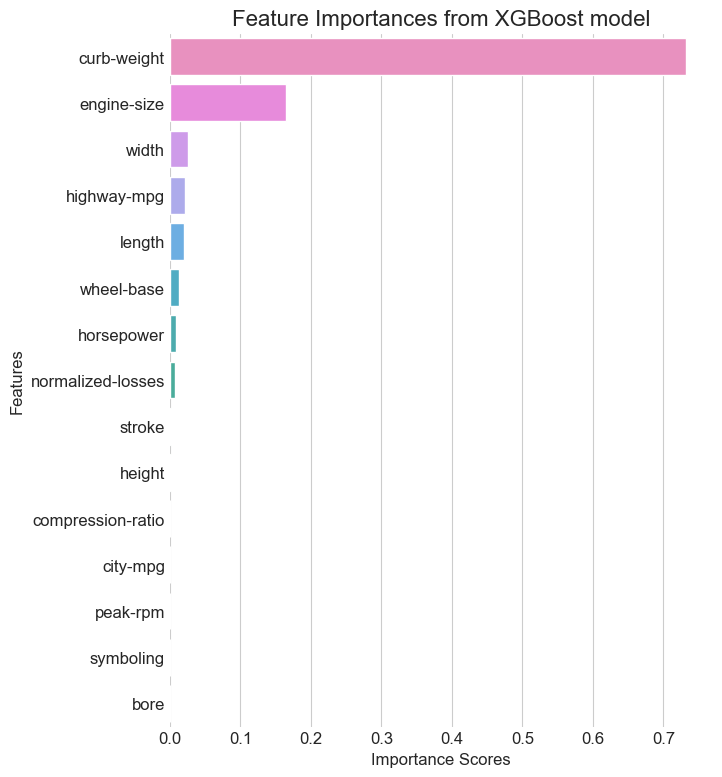

In [154]:
from sklearn.tree import DecisionTreeRegressor


# Initiate model
model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute the performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print the performance metrics
print('RMSE:', round(rmse, 2), 'MAE:', round(mae, 2))


# Extract the feature importances and create a dataframe
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})

# Sort the features by importance
importances = importances.sort_values('Importance', ascending=True)

plot_importances(importances, 'Feature Importances from XGBoost model')


In [155]:
# Select most important features
new_importances = importances[0:n_features]
selected_features = new_importances.Feature.to_list()

print(selected_features)

# Filter X fro selected features
X_train_dt = X_train[selected_features]
X_test_dt = X_test[selected_features]

new_importances

['bore', 'symboling', 'peak-rpm', 'city-mpg', 'compression-ratio', 'height', 'stroke', 'normalized-losses', 'horsepower', 'wheel-base', 'length']


,Feature,Importance
8,bore,0.000004
0,symboling,0.000037
12,peak-rpm,0.000390
13,city-mpg,0.000555
10,compression-ratio,0.000931
5,height,0.001315
9,stroke,0.002372
1,normalized-losses,0.006712
11,horsepower,0.008916
2,wheel-base,0.013641


# Summary

In [157]:
print("\nBase Model:")
reg = fit_linear_reg(X_train, y_train, X_test, y_test)

print("\nFeature selection by Pearson Correlation:")
reg = fit_linear_reg(X_train_corr, y_train, X_test_corr, y_test)

print("\nFeature selection by Spearman's Rank:")
reg = fit_linear_reg(X_train_spearman, y_train, X_test_spearman, y_test)

print("\nFeature selection by RFE:")
reg = fit_linear_reg(X_train_rfe, y_train, X_test_rfe, y_test)

print("\nFeature selection by SFS:")
reg = fit_linear_reg(X_train_sfs, y_train, X_test_sfs, y_test)

print("\nFeature importance by ridge regression:")
eval_regress(ridge, X_train, X_test, y_test)

print("\nFeature selection by lasso regression:")
eval_regress(lasso, X_train, X_test, y_test)

print("\nFeature selection by decision tree feature importances:")
model = fit_linear_reg(X_train_dt, y_train, X_test_dt, y_test)


Base Model:
RMSE: 2589.05 MAE: 2010.8

Feature selection by Pearson Correlation:
RMSE: 2398.24 MAE: 1887.54

Feature selection by Spearman's Rank:
RMSE: 2452.41 MAE: 1941.15

Feature selection by RFE:
RMSE: 2648.56 MAE: 2018.1

Feature selection by SFS:
RMSE: 2519.85 MAE: 1916.7

Feature importance by ridge regression:
RMSE: 2386.68 MAE: 1876.46

Feature selection by lasso regression:
RMSE: 2537.08 MAE: 1969.16

Feature selection by decision tree feature importances:
RMSE: 2431.83 MAE: 1877.27


# Conclusion

In conclusion, our analysis found that Ridge Regression performed best as a feature selection method. It's important to mention that Ridge Regression doesn't explicitly select features; instead, it reduces the coefficients of less important features by applying L2 regularization (learn more about Ridge Regression here). The second-best approach was a filter method, specifically using ANOVA for feature selection. In this case, we identified the top 29 features. Keep in mind that the most effective method depends on your dataset and model, so it's always a good idea to explore different strategies and see what works best for your particular problem.